## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

greyscale

In [81]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [82]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [83]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [84]:
data_dir = Path('data')

In [85]:
RETRAIN = True
RESIZE_IMAGES = True

In [86]:
MODEL_NAME='cv_reflect_101_grey'

In [87]:
NB_NUM='03_16'

In [8]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 1e3b88b3, DATE: 20191112


In [9]:
DATE = '20191112'
UID = '1e3b88b3'

In [10]:
SUB_NUM='19'

In [11]:
img_size=256
border='wrap'

In [12]:
train_images=data_dir/f'train/rotated/clipped/{border}/{img_size}/L'
test_images=data_dir/f'test/rotated/clipped/{border}/{img_size}/L'

In [13]:
test_names = get_image_files(test_images)

In [14]:
assert len(test_names)==7325

In [15]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [16]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [17]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [18]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [19]:
assert len(df_test)==7325

In [20]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [21]:
#xtra_tfms=[dihedral(p=0.5), zoom_crop(scale=(0.8,1.3), p=0.2)] 
xtra_tfms=[dihedral(p=0.5), rand_crop(p=0.2)] 

In [22]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0., xtra_tfms=xtra_tfms)
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [23]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [24]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [25]:
#to check what params object has
#dir(data)

In [26]:
data.label_list

LabelLists;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/wrap/256/L;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/wrap/256/L;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/wrap/256/L

In [27]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

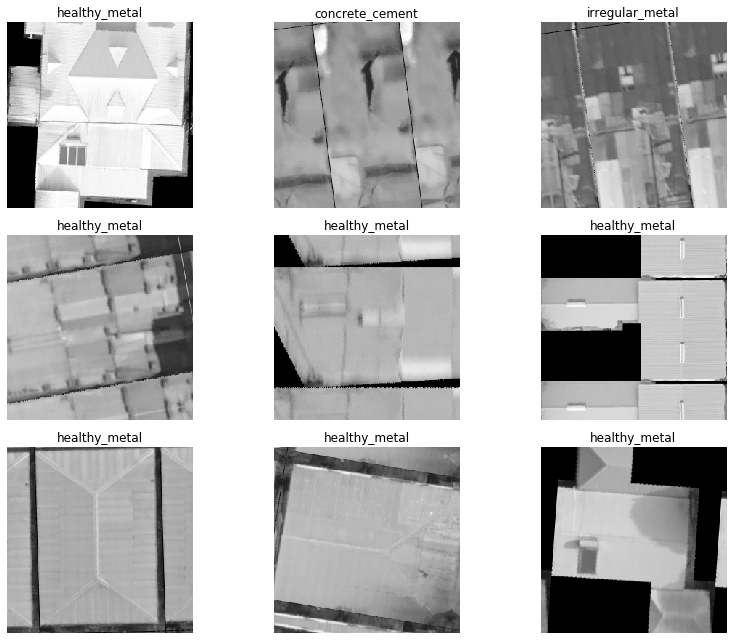

In [28]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [29]:
arch = models.resnet50
arch_name = 'rn50'

In [30]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True)

In [31]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### (Re)train model

In [32]:
if RETRAIN:
    learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


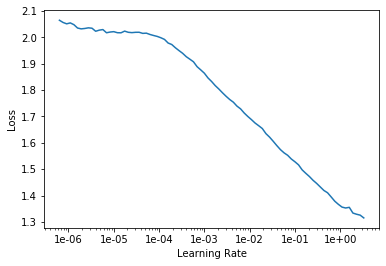

In [33]:
if RETRAIN:
    learn.recorder.plot()

Then we can fit the head of our network.

In [34]:
if RETRAIN:
    lr = 1e-1

In [35]:
if RETRAIN:
    learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.585617,0.623003,0.229047,01:16
1,0.549757,0.728781,0.245455,01:15
2,0.526275,0.696845,0.252550,01:16
3,0.464113,0.454763,0.169180,01:15
4,0.429843,0.428965,0.156763,01:16


<pre>
 epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.502964 	0.597735 	0.208426 	01:11
1 	0.486689 	0.498021 	0.175388 	01:11
2 	0.453843 	0.444588 	0.154767 	01:11
3 	0.415386 	0.416525 	0.147228 	01:11
4 	0.383324 	0.398478 	0.133925 	01:10
    </pre>

In [36]:
if RETRAIN:
    learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')
    #saves in parent of models directory
    #learn.export()

#### Load model

In [37]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/wrap/256/L;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/wrap/256/L;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/wrap/256/L, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, 

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 267),
 ('healthy_metal', 'irregular_metal', 139),
 ('incomplete', 'irregular_metal', 76),
 ('concrete_cement', 'healthy_metal', 44),
 ('other', 'healthy_metal', 36),
 ('healthy_metal', 'concrete_cement', 31),
 ('incomplete', 'concrete_cement', 27),
 ('incomplete', 'healthy_metal', 19),
 ('irregular_metal', 'concrete_cement', 14),
 ('other', 'irregular_metal', 14),
 ('concrete_cement', 'irregular_metal', 12),
 ('concrete_cement', 'incomplete', 9),
 ('irregular_metal', 'incomplete', 9),
 ('irregular_metal', 'other', 3),
 ('healthy_metal', 'incomplete', 2),
 ('other', 'concrete_cement', 2)]

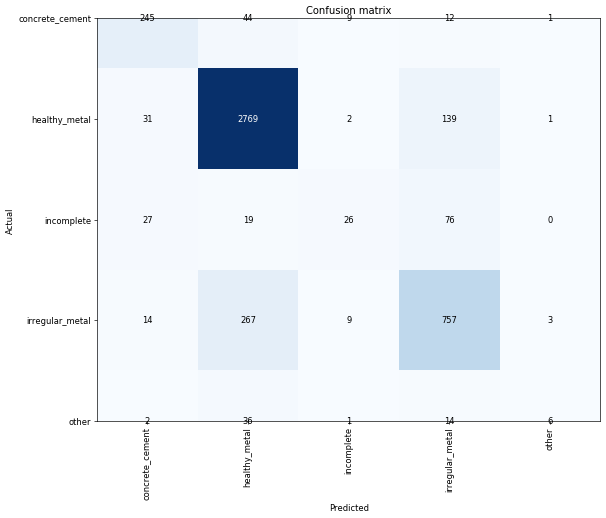

In [39]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [40]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


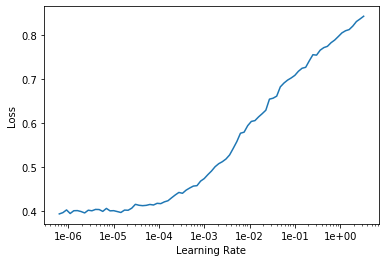

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.462574,0.490704,0.180266,01:39
1,0.474473,0.461450,0.174279,01:39
2,0.445663,0.445431,0.160310,01:40
3,0.417445,0.413118,0.153880,01:39
4,0.384940,0.406859,0.147894,01:39


<pre>
epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.438103 	0.431031 	0.157428 	01:37
1 	0.413694 	0.500094 	0.179823 	01:38
2 	0.405334 	0.394548 	0.143902 	01:35
3 	0.400567 	0.368481 	0.135920 	01:35
4 	0.352880 	0.357799 	0.128381 	01:35
    </pre>

In [43]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [44]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/wrap/256/L;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/wrap/256/L;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/wrap/256/L, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, 

In [45]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.414508,0.476416,0.162306,01:40
1,0.429822,0.439037,0.160754,01:41
2,0.417150,0.436115,0.157871,01:40
3,0.390668,0.413425,0.151885,01:39
4,0.361748,0.404966,0.149002,01:38


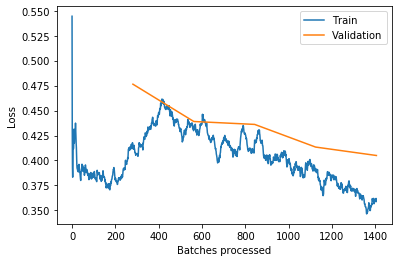

In [46]:
learn.recorder.plot_losses()

In [47]:
learn.save(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [48]:
learn.export(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [ ]:
learn.load(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [49]:
learn.export()

### inference

In [50]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [51]:
len(test_dataset)

7325

In [52]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{border}/{img_size}', test=test_dataset)

In [53]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [54]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [55]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [56]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [57]:
len(learn.dl(DatasetType.Test))

115

Get number of items in the Valid dataset (in DeviceDataLoader)

In [58]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [59]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [60]:
labels = np.argmax(preds, 1)

In [61]:
len(preds)

7325

In [62]:
preds[0].tolist()

[0.0010173958726227283,
 0.9955682158470154,
 0.0007550678565166891,
 0.001240214449353516,
 0.0014190302463248372]

In [63]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [64]:
len(labels)

7325

In [65]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [66]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [67]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [68]:
test_predictions[0]

'healthy_metal'

In [69]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [70]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/wrap/256/L/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/wrap/256/L/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/wrap/256/L/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/wrap/256/L/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/wrap/256/L/7a486800.tif'),
       PosixPath('data/test/rotated/clipped/wrap/256/L/7a4c49fc.tif'),
       PosixPath('data/test/rotated/clipped/wrap/256/L/7a501f50.tif'),
       PosixPath('data/test/rotated/clipped/wrap/256/L/7a4d27b4.tif')], dtype=object)

In [71]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [72]:
preds_list[0]

[0.0010173958726227283,
 0.9955682158470154,
 0.0007550678565166891,
 0.001240214449353516,
 0.0014190302463248372]

In [73]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [74]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [75]:
df.head()

,id,pred
0,7a4d9168,"[0.0010173958726227283, 0.9955682158470154, 0...."
1,7a4ae922,"[0.004886389710009098, 0.9683466553688049, 0.0..."
2,7a48ca98,"[0.010565563105046749, 0.4158533811569214, 0.0..."
3,7a49c614,"[0.006754016038030386, 0.6967122554779053, 0.0..."
4,7a4dd4f2,"[0.007277538999915123, 0.38852939009666443, 0...."


In [76]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [77]:
pred_df.insert(loc=0, column='id', value=ids)

In [78]:
pred_df.columns = cols

In [79]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.001017,0.995568,0.000755,0.001240,0.001419
1,7a4ae922,0.004886,0.968347,0.004727,0.014648,0.007392
2,7a48ca98,0.010566,0.415853,0.010156,0.548408,0.015017
3,7a49c614,0.006754,0.696712,0.003649,0.280515,0.012370
4,7a4dd4f2,0.007278,0.388529,0.006995,0.561768,0.035431


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [ ]:
pred_ids=pred_df['id'].values.tolist()

In [ ]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [ ]:
df_baseline.head()

In [ ]:
baseline_ids=df_baseline['id'].values.tolist()

In [ ]:
baseline_ids

In [ ]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [ ]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [ ]:
pred_df.head()

In [ ]:
pred_df=pred_df.sort_values('id_cat')

In [ ]:
pred_df.head()

In [ ]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [ ]:
#pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [ ]:
### Submission 2: 0.4461


In [ ]:
arch_name = 'rn50'
#pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

In [ ]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")